In [1]:
from data.dataset import TrashnetDataset
import pandas as pd
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
from torchvision.models import resnet50, resnet18
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import tempfile
import seaborn as sns
from torchmetrics import (
    MetricCollection,
    Accuracy,
    Precision,
    Recall,
    F1Score,
    ConfusionMatrix,
    AUROC,
)

import mlflow
from lightning.pytorch.loggers import MLFlowLogger
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers.neptune import NeptuneLogger

/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/pydantic/_internal/_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
train_df = pd.read_csv("./data/dataset/labels-aux-1/labels_aux_train_1.csv")
val_df = pd.read_csv("./data/dataset/labels-aux-1/labels_aux_val_1.csv")
test_df = pd.read_csv("./data/dataset/labels-aux-1/labels_aux_test_1.csv")
train_df

,image_name,class_id,class_name
0,7b8eefef2ad67a78c8dc980788829aa6.jpg,4,plastic
1,ccae50bf4a6b1caae086873ab815392d.jpg,2,metal
2,9df4df47ae2e0cf776c8492cccd1463a.jpg,3,paper
3,05a67edfc93bcde7ddd2d31cc1833933.jpg,1,glass
4,63f7a25b0d426843ddecb0a81636ac2d.jpg,5,trash
...,...,...,...
211,72dd000b31da0d8963a81184373fe798.jpg,3,paper
212,25dc8352df86fe64de523bd9e4201fae.jpg,2,metal
213,53fcd1f0aeefc432388726e73e38fc2d.jpg,4,plastic
214,d57defb1eec094ce3c20f8d64b17a039.jpg,0,cardboard


In [3]:
NUM_CLASSES = len(np.unique(train_df["class_id"]))
NUM_CLASSES

6

In [4]:
TrashnetDataset.class_name_to_class_id[
    "cardboard"
], TrashnetDataset.class_id_to_class_name[0]

(0, 'cardboard')

In [5]:
train_transform = A.Compose(
    [
        # Augmentations
        A.OneOf([A.ElasticTransform(), A.GridDistortion(), A.PiecewiseAffine()]),
        A.OneOf([A.Flip(), A.Rotate()]),
        A.OneOf([A.FancyPCA(), A.RGBShift(), A.ChannelShuffle()]),
        A.RandomBrightnessContrast(p=0.3),
        A.Affine(translate_percent=(-0.2, 0.2)),
        A.CoarseDropout(max_holes=25),
        # Normalization
        A.Normalize(
            TrashnetDataset.RGB_MEANS, TrashnetDataset.RGB_STD, max_pixel_value=255.0
        ),
        ToTensorV2(),
    ]
)

val_test_transform = A.Compose(
    [
        # Normalization
        A.Normalize(
            TrashnetDataset.RGB_MEANS, TrashnetDataset.RGB_STD, max_pixel_value=255.0
        ),
        ToTensorV2(),
    ]
)

In [6]:
BATCH_SIZE = 4
train_ds = TrashnetDataset(
    images_dir="data/dataset/images/",
    df=train_df,
    transform=train_transform,
)
train_ds_loader = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)

val_ds = TrashnetDataset(
    images_dir="data/dataset/images/",
    df=val_df,
    transform=val_test_transform,
)
val_ds_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

test_ds = TrashnetDataset(
    images_dir="data/dataset/images/",
    df=test_df,
    transform=val_test_transform,
)
test_ds_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [7]:
class LossTracker:
    def __init__(self) -> None:
        self.running_loss = 0
        self.current_batch_loss = 0
        self.current_reduced_loss = 0
        self.epoch_loss = 0
        self.samples_n = 0

    def update(self, loss, batch_size):
        # Remove mean reduction by multiplying by batch_size
        self.current_batch_loss = loss * batch_size
        self.running_loss += self.current_batch_loss
        self.samples_n += batch_size
        self.epoch_loss = self.running_loss / self.samples_n
        self.current_reduced_loss = loss

    def reset(self):
        self.running_loss = 0
        self.current_batch_loss = 0
        self.current_reduced_loss = 0
        self.epoch_loss = 0
        self.samples_n = 0

In [12]:
class TrashnetClassifier(pl.LightningModule):
    def __init__(
        self,
        classifier: nn.Module,
        loss: nn.functional=nn.functional.cross_entropy,
        classes_n: int=6,
        upper_quantile: float=0.9,
        bottom_quantile: float=0.1
    ):
        super().__init__()
        # Lightning System components
        self.classifier = classifier
        self.loss = loss

        # Loss trackers TODO: Move class definition here
        self.train_loss_tracker = LossTracker()
        self.val_loss_tracker = LossTracker()
        self.test_loss_tracker = LossTracker()

        # Metadata
        self.classes_n = classes_n
        self.upper_quantile = upper_quantile
        self.lower_quantile = bottom_quantile

        # Miscelanous
        self.test_results = pd.DataFrame({"image_name": [], "loss": []})

        # Metrics TODO: Make some setup function to clear up __init__
        self.val_metrics_tracker = MetricCollection(
            {
                "accuracy_micro": Accuracy(
                    task="multiclass", num_classes=classes_n, average="micro"
                ),
                "precision": Precision(
                    task="multiclass", num_classes=classes_n, average="none"
                ),
                "recall": Recall(
                    task="multiclass", num_classes=classes_n, average="none"
                ),
                "f1_score": F1Score(
                    task="multiclass", num_classes=classes_n, average="none"
                ),
                "auroc": AUROC(
                    task="multiclass", num_classes=classes_n, average="none"
                ),
            },
        )
        self.test_metrics_tracker = self.val_metrics_tracker.clone()
        self.test_metrics_tracker.add_metrics(
            {
                "confusion_matrix": ConfusionMatrix(
                    task="multiclass", num_classes=classes_n, normalize="true"
                )
            }
        )

    ################################################################################
    # Training                                                                     #
    ################################################################################
    def training_step(self, batch, batch_idx):
        _, x, targets = batch
        preds = self.classifier(x)
        loss = self.loss(preds, targets)
        self.train_loss_tracker.update(loss, len(batch))
        return self.train_loss_tracker.current_reduced_loss

    def on_train_epoch_end(self):
        self._log_train_loss(self.train_loss_tracker.epoch_loss)
        self.train_loss_tracker.reset()

    def _log_train_loss(self, epoch_loss):
        self.logger.experiment.log_metric(
            self.logger.run_id, f"train/loss", epoch_loss, step=self.current_epoch
        )

    ################################################################################
    # Validation                                                                   #
    ################################################################################
    def validation_step(self, batch, batch_idx):
        _, x, targets = batch
        preds = self.classifier(x)
        loss = self.loss(preds, targets)
        self.val_loss_tracker.update(loss, len(batch))
        self.val_metrics_tracker.update(preds, targets)
        return self.val_loss_tracker.current_reduced_loss

    def on_validation_epoch_end(self):
        computed_metrics = self.val_metrics_tracker.compute()
        if not self.trainer.sanity_checking:
            self._log_val_metrics(computed_metrics)
            self._log_val_loss(self.val_loss_tracker.epoch_loss)
        self.val_metrics_tracker.reset()
        self.val_loss_tracker.reset()

    def _log_val_loss(self, epoch_loss):
        self._mlflow_log_metric("val/loss", epoch_loss)

    def _log_val_metrics(self, computed_metrics):
        self._mlflow_log_metric(
            "val/accuracy_micro", computed_metrics.pop("accuracy_micro")
        )
        for metric_name, metric_values in computed_metrics.items():
            # Macro averaged
            self._mlflow_log_metric(
                f"val/{metric_name}_macro", torch.mean(metric_values)
            )
            # None averaged
            for i, value in enumerate(metric_values):
                class_name = self.class_id_to_class_name(i)
                self._mlflow_log_metric(
                    f"val/per_class/{class_name}/{metric_name}", value
                )

    ################################################################################
    # Testing                                                                      #
    ################################################################################
    def test_step(self, batch, batch_idx):
        idxs, x, targets = batch
        preds = self.classifier(x)
        self.test_metrics_tracker.update(preds, targets)
        # Log loss for each image separately for later human evaluation
        losses = self.loss(preds, targets, reduction="none")
        partial = pd.DataFrame(
            {
                "image_name": [self.image_idx_to_image_name("test", i.item()) for i in idxs],
                "loss": losses.tolist(),
            }
        )
        self.test_results = pd.concat([self.test_results, partial])
        # Mean is calculated because tracker expects reduction in loss
        self.test_loss_tracker.update(torch.mean(losses), len(batch))

    def on_test_epoch_end(self):
        computed_metrics = self.test_metrics_tracker.compute()
        self._log_test_metrics(computed_metrics)
        self._log_test_loss(self.test_loss_tracker.epoch_loss)
        self._log_per_instance_test_loss(self.test_results)
        self.test_metrics_tracker.reset()
        self.test_loss_tracker.reset()

    def _log_test_metrics(self, computed_metrics):
        self._mlflow_log_metric(
            "test/accuracy_micro", computed_metrics.pop("accuracy_micro")
        )
        # Confusion matrix from seaborn figure
        plt.clf()
        confusion_matrix_figure = sns.heatmap(
            computed_metrics.pop("confusion_matrix").cpu(),
            xticklabels=[self.class_id_to_class_name(i) for i in range(self.classes_n)],
            yticklabels=[self.class_id_to_class_name(i) for i in range(self.classes_n)],
            annot=True,
        ).figure
        self.logger.experiment.log_figure(
            self.logger.run_id, confusion_matrix_figure, "figures/confusion_matrix.png"
        )
        for metric_name, metric_values in computed_metrics.items():
            # Macro averaged
            self._mlflow_log_metric(
                f"test/{metric_name}_macro", torch.mean(metric_values)
            )
            # None averaged
            for i, value in enumerate(metric_values):
                class_name = self.class_id_to_class_name(i)
                self._mlflow_log_metric(
                    f"test/per_class/{class_name}/{metric_name}", value
                )

    def _log_test_loss(self, epoch_loss):
        self._mlflow_log_metric("test/loss", epoch_loss)

    def _log_per_instance_test_loss(self, per_image_test_loss: pd.DataFrame):
        # Log csv with losses
        with tempfile.TemporaryDirectory() as tempdir:
            csv_filepath = os.path.join(tempdir, "per_image_loss.csv")
            per_image_test_loss.to_csv(csv_filepath, index=False)
            self.logger.experiment.log_artifact(self.logger.run_id, csv_filepath)

        # Log histogram with distribution of losses
        plt.clf()
        hist = sns.histplot(per_image_test_loss["loss"], kde=False).figure
        self.logger.experiment.log_figure(
            self.logger.run_id, hist, "figures/per_image_loss_hist.png"
        )

        # Log top K and bottom L images as artifacts
        test_data_dir = self.trainer.test_dataloaders.dataset.images_dir
        top_q = per_image_test_loss[per_image_test_loss['loss'] > per_image_test_loss['loss'].quantile(self.upper_quantile)]
        top_q.apply(
            lambda x: self.logger.experiment.log_artifact(
                self.logger.run_id,
                os.path.join(test_data_dir, x["image_name"]),
                artifact_path=f"per_image_performance_by_loss/upper_quantile/{x['loss']}",
            ),
            axis=1,
        )
        self.logger.experiment.log_param(self.logger.run_id, 'upper_quantile', self.upper_quantile)

        bot_q = per_image_test_loss[per_image_test_loss['loss'] < per_image_test_loss['loss'].quantile(self.lower_quantile)]
        bot_q.apply(
            lambda x: self.logger.experiment.log_artifact(
                self.logger.run_id,
                os.path.join(test_data_dir, x["image_name"]),
                artifact_path=f"per_image_performance_by_loss/lower_quantile/{x['loss']}",
            ),
            axis=1,
        )
        self.logger.experiment.log_param(self.logger.run_id, 'lower_quantile', self.lower_quantile)

    ################################################################################
    # Other                                                                        #
    ################################################################################
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def _mlflow_log_metric(self, name, value):
        self.logger.experiment.log_metric(
            self.logger.run_id, name, value, step=self.current_epoch
        )

    def class_id_to_class_name(self, id):
        # Pick any available
        dataloaders = [
            self.trainer.train_dataloader,
            self.trainer.val_dataloaders,
            self.trainer.test_dataloaders,
            self.trainer.predict_dataloaders,
        ]
        for dl in dataloaders:
            if dl is not None:
                return dl.dataset.class_id_to_class_name[id]

    def image_idx_to_image_name(self, dataloader, idx):
        df = None
        if dataloader == "train":
            df = self.trainer.train_dataloader.dataset.df
        elif dataloader == "val":
            df = self.trainer.val_dataloaders.dataset.df
        elif dataloader == "test":
            df = self.trainer.test_dataloaders.dataset.df
        elif dataloader == "predict":
            df = self.trainer.predict_dataloaders.dataset.df
        return df.iloc[idx, df.columns.get_loc('image_name')]

In [13]:
model = resnet50(weights="IMAGENET1K_V1")
fc_in_features_n = model.fc.in_features
model.fc = nn.Linear(fc_in_features_n, NUM_CLASSES)

In [14]:
loss = nn.functional.cross_entropy
# loss = nn.MultiMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
predictor = TrashnetClassifier(
    model,
    loss,
    NUM_CLASSES,
    upper_quantile=0.9,
    bottom_quantile=0.1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/10/17 20:34:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:351: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.8 and may not succeed with packages outside this range."


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type             | Params
----------------------------------------------------------
0 | classifier           | ResNet           | 23.5 M
1 | val_metrics_tracker  | MetricCollection | 0     
2 | test_metrics_tracker | MetricCollection | 0     
----------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.081    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs f

Epoch 2: 100%|██████████| 6/6 [00:04<00:00,  1.45it/s, v_num=fc70]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 6/6 [00:04<00:00,  1.24it/s, v_num=fc70]


/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at ./mlruns/0/e79ad15105434f55820a4de5eeb5fc70/checkpoints/epoch=2-step=18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/0/e79ad15105434f55820a4de5eeb5fc70/checkpoints/epoch=2-step=18.ckpt
/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num

Testing DataLoader 0: 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


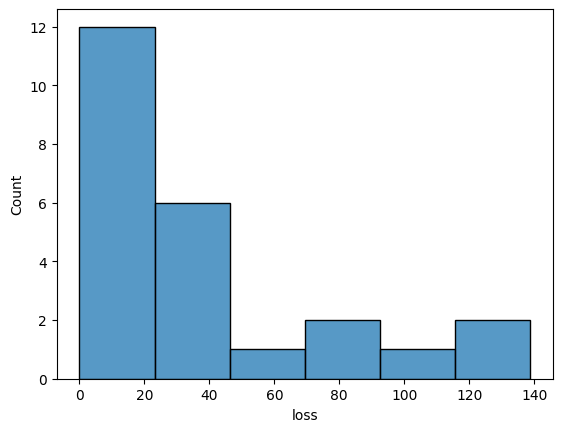

In [15]:
# TODO SEE THIS
# running loss - https://stackoverflow.com/questions/61092523/what-is-running-loss-in-pytorch-and-how-is-it-calculated
# mean of loss - https://cs231n.github.io/linear-classify/

# mlflow.set_tracking_uri("file:/home/js/Projects/android-trash-classification/mlruns")
mlflow.pytorch.autolog()
with mlflow.start_run() as run:
    mlflow.get_artifact_uri()
    mlflow_logger = MLFlowLogger(run_id=run.info.run_id)
    trainer = pl.Trainer(
        max_epochs=3,
        # accumulate_grad_batches=4,
        logger=mlflow_logger  # TODO: Logger logs twice! But it's necessary for image logging
        # callbacks=[
        # EarlyStopping(monitor='auroc_macro', mode=)
        # ]
    )

    trainer.fit(
        model=predictor,
        train_dataloaders=val_ds_loader,  # train_ds_loader, # TODO CHANGE THIS
        val_dataloaders=val_ds_loader,
    )
    # TODO: Add check if the idx_to_image_name_test is correctly provided
    # Check on test epoch start
    trainer.test(dataloaders=(val_ds_loader))  # TODO: CHANGE THIS
mlflow.end_run()